In [278]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler,
    Normalizer, QuantileTransformer, PowerTransformer
)
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
sns.set_theme()



In [279]:
SmallDS_df = pd.read_csv('./clean_data/clean_SmallDS.csv')

In [280]:
SmallDS_new_df = SmallDS_df[['Quan','DienTich(m2)', 'GiaBan', 'PhongNgu', 'PhongVeSinh', 'TinhTrangBDS', 'TinhTrangGiayTo',
                 'TinhTrangNoiThat', 'HuongBanCong', 'HuongCua']]
SmallDS_new_df.head(3)

,Quan,DienTich(m2),GiaBan,PhongNgu,PhongVeSinh,TinhTrangBDS,TinhTrangGiayTo,TinhTrangNoiThat,HuongBanCong,HuongCua
0,Thành phố Thủ Đức,58.00,1.70,2.0,NaN,Đã bàn giao,NaN,Nội thất đầy đủ,NaN,NaN
1,Quận 7,162.75,8.00,4.0,3.0,Chưa bàn giao,NaN,NaN,NaN,Tây
2,Thành phố Thủ Đức,56.00,1.67,2.0,1.0,Đã bàn giao,Đã có sổ,NaN,NaN,NaN


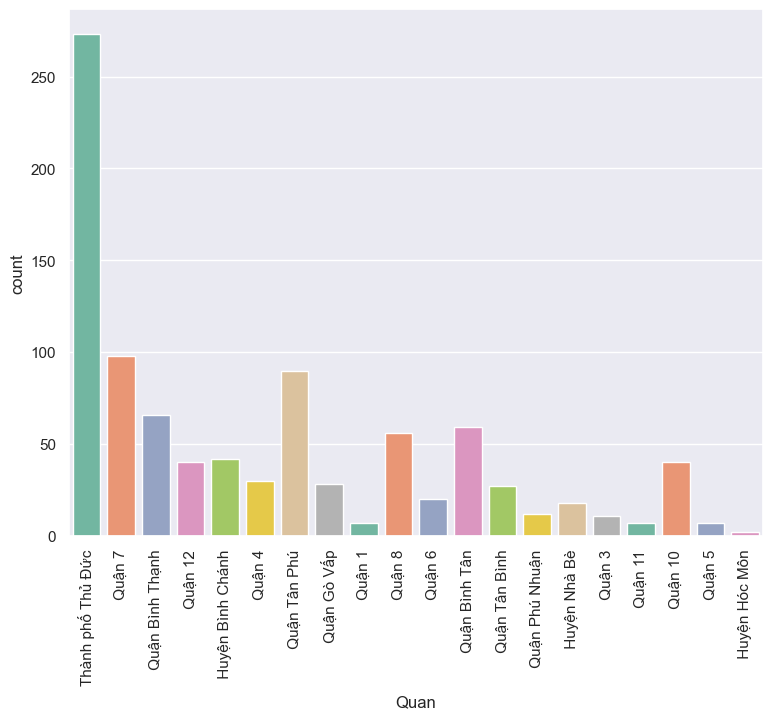

In [281]:
plt.figure(figsize=(15, 20))
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x=SmallDS_new_df['Quan'], palette="Set2")
ax1.set_xticklabels(SmallDS_new_df['Quan'].unique(), rotation=90)
plt.tight_layout()
plt.show()

=> chuyển qua file clean để làm sạch những nhà có S <

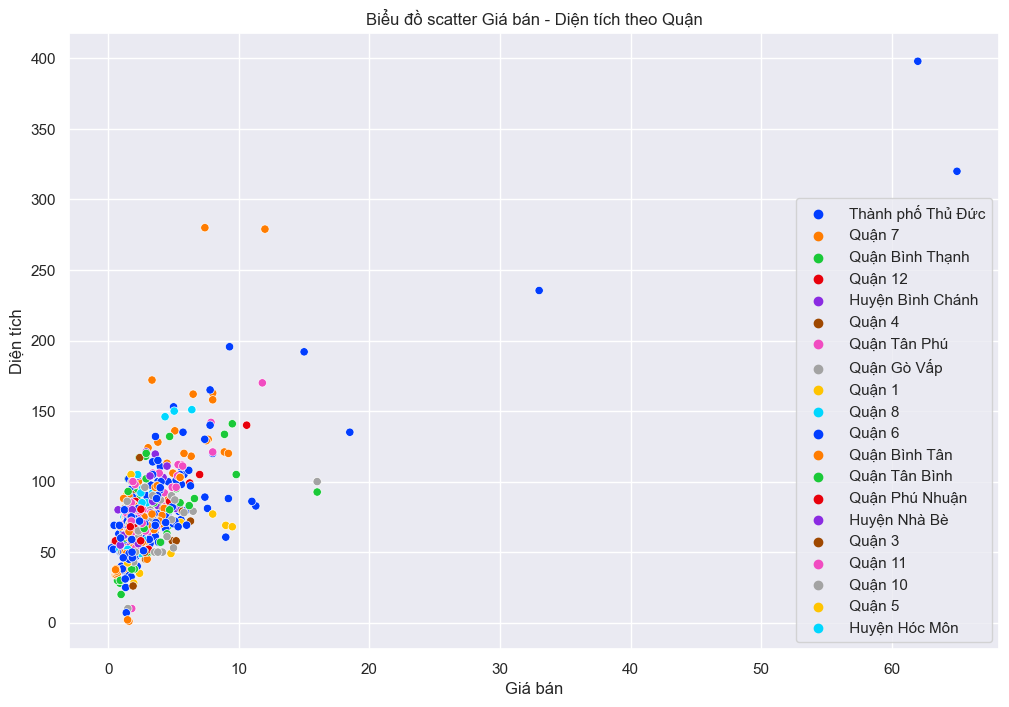

In [282]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='GiaBan', y='DienTich(m2)', hue='Quan', data=SmallDS_new_df, palette='bright')
plt.xlabel('Giá bán')
plt.ylabel('Diện tích')
plt.title('Biểu đồ scatter Giá bán - Diện tích theo Quận')
plt.legend()
plt.grid(True)
plt.show()

In [283]:
SmallDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              933 non-null    object 
 1   DienTich(m2)      933 non-null    float64
 2   GiaBan            933 non-null    float64
 3   PhongNgu          933 non-null    float64
 4   PhongVeSinh       806 non-null    float64
 5   TinhTrangBDS      933 non-null    object 
 6   TinhTrangGiayTo   282 non-null    object 
 7   TinhTrangNoiThat  201 non-null    object 
 8   HuongBanCong      123 non-null    object 
 9   HuongCua          191 non-null    object 
dtypes: float64(4), object(6)
memory usage: 73.0+ KB


In [284]:
SmallDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [285]:
SmallDS_new_df["TinhTrangBDS"].unique()

array(['Đã bàn giao', 'Chưa bàn giao'], dtype=object)

In [286]:
SmallDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [287]:
SmallDS_new_df["Quan"].unique()

array([' Thành phố Thủ Đức', ' Quận 7', ' Quận Bình Thạnh', ' Quận 12',
       ' Huyện Bình Chánh', ' Quận 4', ' Quận Tân Phú', ' Quận Gò Vấp',
       ' Quận 1', ' Quận 8', ' Quận 6', ' Quận Bình Tân',
       ' Quận Tân Bình', ' Quận Phú Nhuận', ' Huyện Nhà Bè', ' Quận 3',
       ' Quận 11', ' Quận 10', ' Quận 5', ' Huyện Hóc Môn'], dtype=object)

In [288]:
SmallDS_new_df["TinhTrangNoiThat"].unique()

array(['Nội thất đầy đủ', nan, 'Nhà trống', 'Bàn giao thô',
       'Nội thất cao cấp'], dtype=object)

In [289]:
SmallDS_new_df["HuongBanCong"].unique()

array([nan, 'Đông', 'Tây', 'Đông Nam', 'Đông Bắc', 'Nam', 'Tây Bắc',
       'Bắc', 'Tây Nam'], dtype=object)

In [290]:
SmallDS_new_df["HuongCua"].unique()

array([nan, 'Tây', 'Bắc', 'Nam', 'Tây Bắc', 'Đông', 'Đông Nam', 'Tây Nam',
       'Đông Bắc'], dtype=object)

- Chuyển đổi dữ liệu sang dạng số và xử lý dữ liệu trống


In [291]:
def Convert_TinhTrangBDS(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangBDS'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['TinhTrangBDS'] = SmallDS_new_df['TinhTrangBDS'].astype(float)
    return SmallDS_new_df 

- Xử lý cột 'PhongVeSinh'


In [292]:
def Impute_missing_PhongVeSinh(SmallDS_new_df, impute_method, SmallDS_train=None):
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['PhongVeSinh'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['PhongVeSinh'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['PhongVeSinh'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['PhongVeSinh'].mean() if impute_method == 'mean' else \
                    SmallDS_train['PhongVeSinh'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['PhongVeSinh'].median() if impute_method == 'median' else None
    SmallDS_new_df['PhongVeSinh'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lý cột 'TinhTrangGiayTo'


In [293]:
def Convert_TinhTrangGiayTo(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangGiayTo'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['TinhTrangGiayTo'] = SmallDS_new_df['TinhTrangGiayTo'].astype(float)
    return SmallDS_new_df
def Impute_missing_TinhTrangGiayTo(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_TinhTrangGiayTo(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['TinhTrangGiayTo'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['TinhTrangGiayTo'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['TinhTrangGiayTo'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['TinhTrangGiayTo'].mean() if impute_method == 'mean' else \
                    SmallDS_train['TinhTrangGiayTo'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['TinhTrangGiayTo'].median() if impute_method == 'median' else None
    SmallDS_new_df['TinhTrangGiayTo'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lý cột 'TinhTrangNoiThat'


In [294]:
def Convert_TinhTrangNoiThat(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangNoiThat'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['TinhTrangNoiThat'] = SmallDS_new_df['TinhTrangNoiThat'].astype(float)
    return SmallDS_new_df
def Impute_missing_TinhTrangNoiThat(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_TinhTrangNoiThat(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['TinhTrangNoiThat'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['TinhTrangNoiThat'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['TinhTrangNoiThat'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['TinhTrangNoiThat'].mean() if impute_method == 'mean' else \
                    SmallDS_train['TinhTrangNoiThat'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['TinhTrangNoiThat'].median() if impute_method == 'median' else None
    SmallDS_new_df['TinhTrangNoiThat'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lí cột 'HuongBanCong'


In [295]:
def Convert_HuongBanCong(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongBanCong'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['HuongBanCong'] = SmallDS_new_df['HuongBanCong'].astype(float)
    return SmallDS_new_df
def Impute_missing_HuongBanCong(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_HuongBanCong(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['HuongBanCong'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['HuongBanCong'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['HuongBanCong'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['HuongBanCong'].mean() if impute_method == 'mean' else \
                    SmallDS_train['HuongBanCong'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['HuongBanCong'].median() if impute_method == 'median' else None
    SmallDS_new_df['HuongBanCong'].fillna(fill_value, inplace=True)
    return SmallDS_new_df


- Xử lí trên cột 'HuongCua'


In [296]:
def Convert_HuongCua(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongCua'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['HuongCua'] = SmallDS_new_df['HuongCua'].astype(float)
    return SmallDS_new_df
def Impute_missing_HuongCua(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_HuongCua(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['HuongCua'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['HuongCua'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['HuongCua'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['HuongCua'].mean() if impute_method == 'mean' else \
                    SmallDS_train['HuongCua'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['HuongCua'].median() if impute_method == 'median' else None
    SmallDS_new_df['HuongCua'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lí dữ liệu trên cột 'Quan'


In [297]:
def Convert_Quan(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['Quan'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['Quan'] = SmallDS_new_df['Quan'].astype(float)
    return SmallDS_new_df
def Impute_missing_Quan(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_Quan(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['Quan'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['Quan'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['Quan'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['Quan'].mean() if impute_method == 'mean' else \
                    SmallDS_train['Quan'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['Quan'].median() if impute_method == 'median' else None
    SmallDS_new_df['Quan'].fillna(fill_value, inplace=True)
    return SmallDS_new_df


In [298]:
SmallDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              933 non-null    object 
 1   DienTich(m2)      933 non-null    float64
 2   GiaBan            933 non-null    float64
 3   PhongNgu          933 non-null    float64
 4   PhongVeSinh       806 non-null    float64
 5   TinhTrangBDS      933 non-null    object 
 6   TinhTrangGiayTo   282 non-null    object 
 7   TinhTrangNoiThat  201 non-null    object 
 8   HuongBanCong      123 non-null    object 
 9   HuongCua          191 non-null    object 
dtypes: float64(4), object(6)
memory usage: 73.0+ KB


# Chia train, test, val

In [299]:
X_SmallDS = SmallDS_new_df.drop(columns=['GiaBan'])
y_SmallDS = np.log(SmallDS_new_df['GiaBan'])
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_SmallDS,y_SmallDS,test_size=0.4,random_state=20)
X_test_s, X_val_s, y_test_s, y_val_s = train_test_split(X_test_s, y_test_s, test_size=0.5, random_state=20)

# Xử lí dữ liệu trống

- Xử lí trên cột 'PhongVeSinh'


In [300]:
X_train_s = Impute_missing_PhongVeSinh(X_train_s,'median')
X_test_s = Impute_missing_PhongVeSinh(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_PhongVeSinh(X_val_s,'median',X_train_s)
# Xử lí trên cột 'TinhTrangGiayTo'
X_train_s = Impute_missing_TinhTrangGiayTo(X_train_s,'median')
X_test_s = Impute_missing_TinhTrangGiayTo(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_TinhTrangGiayTo(X_val_s,'median',X_train_s)
# - Xử lí trên cột 'TinhTrangNoiThat'
X_train_s = Impute_missing_TinhTrangNoiThat(X_train_s,'median')
X_test_s = Impute_missing_TinhTrangNoiThat(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_TinhTrangNoiThat(X_val_s,'median',X_train_s)
# Cột hướng ban công
X_train_s = Impute_missing_HuongBanCong(X_train_s,'median')
X_test_s = Impute_missing_HuongBanCong(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_HuongBanCong(X_val_s,'median',X_train_s)
# Cột hướng cửa
X_train_s = Impute_missing_HuongCua(X_train_s,'median')
X_test_s = Impute_missing_HuongCua(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_HuongCua(X_val_s,'median',X_train_s)
# Quận
X_train_s = Impute_missing_Quan(X_train_s,'median')
X_test_s = Impute_missing_Quan(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_Quan(X_val_s,'median',X_train_s)
# Cột tình trạng bất động sản
X_train_s = Convert_TinhTrangBDS(X_train_s)
X_test_s = Convert_TinhTrangBDS(X_test_s)
X_val_s = Convert_TinhTrangBDS(X_val_s)

In [301]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 691 to 355
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              559 non-null    float64
 1   DienTich(m2)      559 non-null    float64
 2   PhongNgu          559 non-null    float64
 3   PhongVeSinh       559 non-null    float64
 4   TinhTrangBDS      559 non-null    float64
 5   TinhTrangGiayTo   559 non-null    float64
 6   TinhTrangNoiThat  559 non-null    float64
 7   HuongBanCong      559 non-null    float64
 8   HuongCua          559 non-null    float64
dtypes: float64(9)
memory usage: 43.7 KB


In [302]:
X_test_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 731 to 708
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              187 non-null    float64
 1   DienTich(m2)      187 non-null    float64
 2   PhongNgu          187 non-null    float64
 3   PhongVeSinh       187 non-null    float64
 4   TinhTrangBDS      187 non-null    float64
 5   TinhTrangGiayTo   187 non-null    float64
 6   TinhTrangNoiThat  187 non-null    float64
 7   HuongBanCong      187 non-null    float64
 8   HuongCua          187 non-null    float64
dtypes: float64(9)
memory usage: 14.6 KB


In [303]:
X_val_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 195 to 414
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              187 non-null    float64
 1   DienTich(m2)      187 non-null    float64
 2   PhongNgu          187 non-null    float64
 3   PhongVeSinh       187 non-null    float64
 4   TinhTrangBDS      187 non-null    float64
 5   TinhTrangGiayTo   187 non-null    float64
 6   TinhTrangNoiThat  187 non-null    float64
 7   HuongBanCong      187 non-null    float64
 8   HuongCua          187 non-null    float64
dtypes: float64(9)
memory usage: 14.6 KB


In [304]:
train_data = X_train_s.join(y_train_s)

array([[<AxesSubplot:title={'center':'Quan'}>,
        <AxesSubplot:title={'center':'DienTich(m2)'}>,
        <AxesSubplot:title={'center':'PhongNgu'}>],
       [<AxesSubplot:title={'center':'PhongVeSinh'}>,
        <AxesSubplot:title={'center':'TinhTrangBDS'}>,
        <AxesSubplot:title={'center':'TinhTrangGiayTo'}>],
       [<AxesSubplot:title={'center':'TinhTrangNoiThat'}>,
        <AxesSubplot:title={'center':'HuongBanCong'}>,
        <AxesSubplot:title={'center':'HuongCua'}>]], dtype=object)

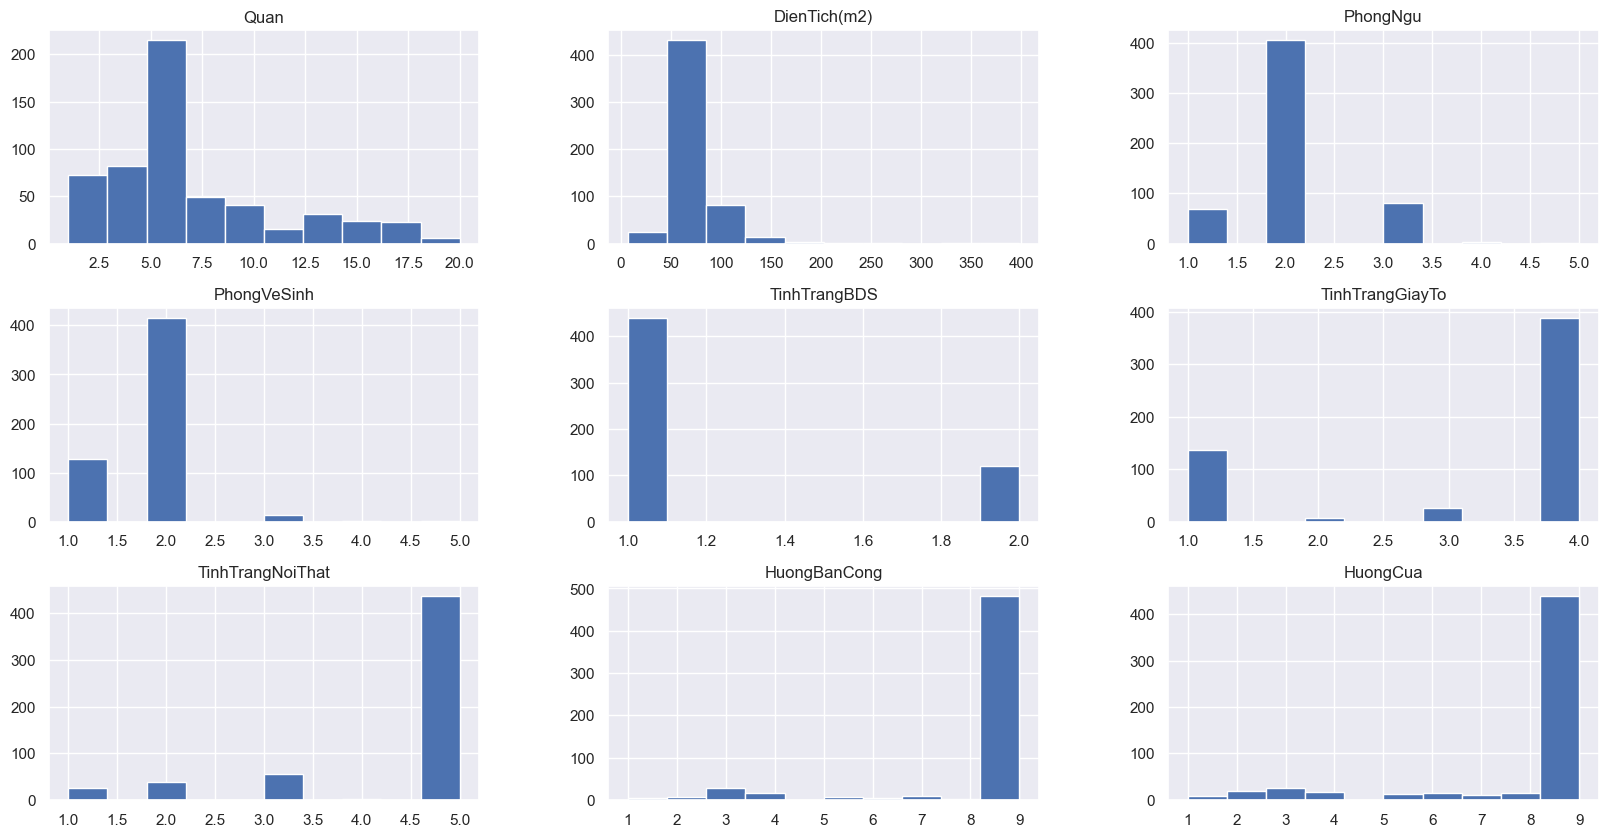

In [305]:
X_train_s.hist(figsize=(20,10))

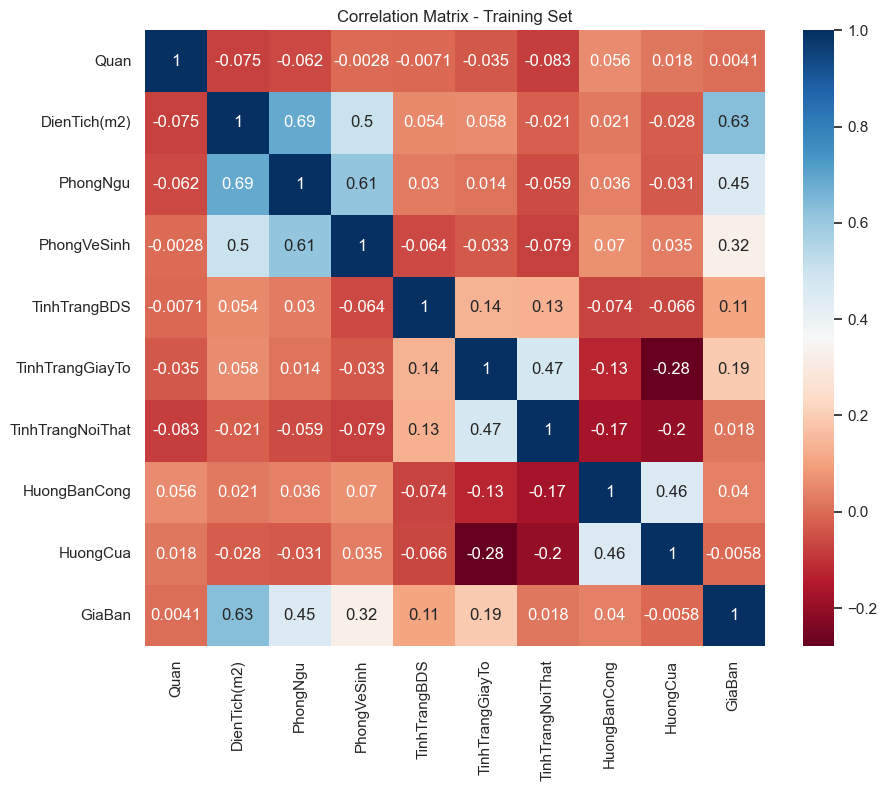

In [306]:
correlation_matrix = X_train_s.copy()
correlation_matrix['GiaBan'] = y_train_s
correlation_matrix = correlation_matrix.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu')  
plt.title('Correlation Matrix - Training Set')
plt.show()  


In [307]:
k_best = SelectKBest(f_regression, k=5)
X_train_selected = k_best.fit_transform(X_train_s, y_train_s)
selected_features = X_train_s.columns[k_best.get_support()]
X_val_selected = k_best.transform(X_val_s)
X_test_selected = k_best.transform(X_test_s)
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['DienTich(m2)', 'PhongNgu', 'PhongVeSinh', 'TinhTrangBDS',
       'TinhTrangGiayTo'],
      dtype='object')


* Lựa chọn đặc trưng

In [308]:
X_train_s = X_train_s[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_val_s = X_val_s[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_test_s = X_test_s[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]

### Xem tác động các tính năng đến giá bán

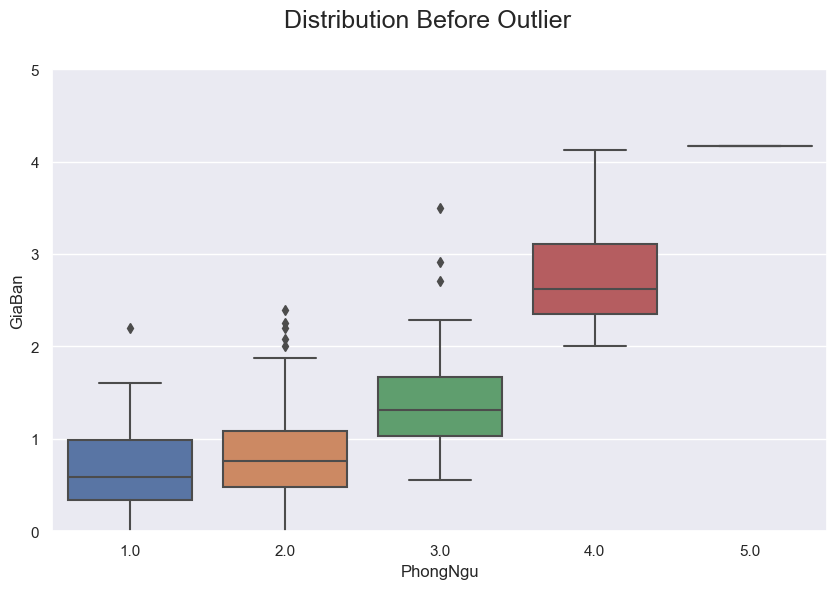

In [309]:
var = 'PhongNgu'
data = pd.concat([y_train_s, X_train_s['PhongNgu']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.suptitle("Distribution Before Outlier", fontsize = 18)
plt.ylim(0, 5)
plt.show()

In [310]:
norm_upper_limit_train = X_train_s['PhongNgu'].mean() + 3 * X_train_s['PhongNgu'].std()
norm_lower_limit_train = X_train_s['PhongNgu'].mean() - 3 * X_train_s['PhongNgu'].std()
norm_upper_limit_test = X_test_s['PhongNgu'].mean() + 3 * X_test_s['PhongNgu'].std()
norm_lower_limit_test = X_test_s['PhongNgu'].mean() - 3 * X_test_s['PhongNgu'].std()
norm_upper_limit_val = X_val_s['PhongNgu'].mean() + 3 * X_val_s['PhongNgu'].std()
norm_lower_limit_val = X_val_s['PhongNgu'].mean() - 3 * X_val_s['PhongNgu'].std()

In [311]:
df_normal_new_train = X_train_s[(X_train_s['PhongNgu'] > norm_lower_limit_train) & ( X_train_s['PhongNgu'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['PhongNgu'] > norm_lower_limit_test) & ( X_test_s['PhongNgu'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['PhongNgu'] > norm_lower_limit_val) & ( X_val_s['PhongNgu'] < norm_upper_limit_val)]

In [312]:
print("Before Triming Size:", X_train_s.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 559
After Triming Size: 554


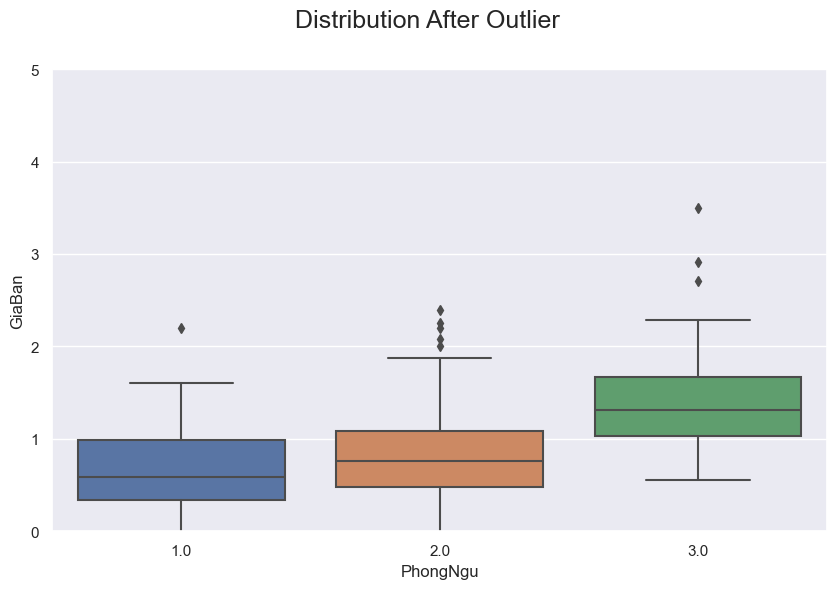

In [313]:
var = 'PhongNgu'
data = pd.concat([y_train_s, df_normal_new_train['PhongNgu']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.suptitle("Distribution After Outlier", fontsize = 18)
plt.ylim(0, 5)
plt.show()

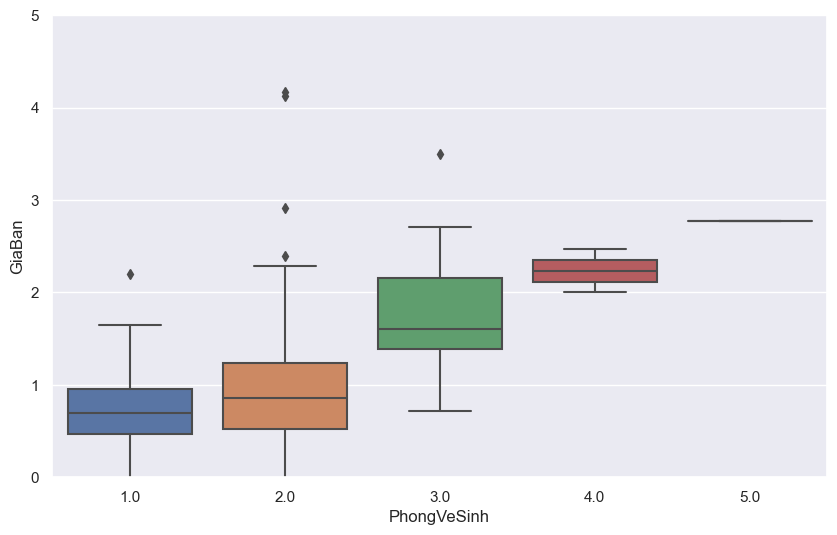

In [314]:
var = 'PhongVeSinh'
data = pd.concat([y_train_s, X_train_s['PhongVeSinh']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.ylim(0, 5) 
plt.show()

In [315]:
norm_upper_limit_train = X_train_s['PhongVeSinh'].mean() + 3 * X_train_s['PhongVeSinh'].std()
norm_lower_limit_train = X_train_s['PhongVeSinh'].mean() - 3 * X_train_s['PhongVeSinh'].std()
norm_upper_limit_test = X_test_s['PhongVeSinh'].mean() + 3 * X_test_s['PhongVeSinh'].std()
norm_lower_limit_test = X_test_s['PhongVeSinh'].mean() - 3 * X_test_s['PhongVeSinh'].std()
norm_upper_limit_val = X_val_s['PhongVeSinh'].mean() + 3 * X_val_s['PhongVeSinh'].std()
norm_lower_limit_val = X_val_s['PhongVeSinh'].mean() - 3 * X_val_s['PhongVeSinh'].std()

In [316]:
df_normal_new_train = X_train_s[(X_train_s['PhongVeSinh'] > norm_lower_limit_train) & ( X_train_s['PhongVeSinh'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['PhongVeSinh'] > norm_lower_limit_test) & ( X_test_s['PhongVeSinh'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['PhongVeSinh'] > norm_lower_limit_val) & ( X_val_s['PhongVeSinh'] < norm_upper_limit_val)]

In [317]:
print("Before Triming Size:", X_train_s.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 559
After Triming Size: 556


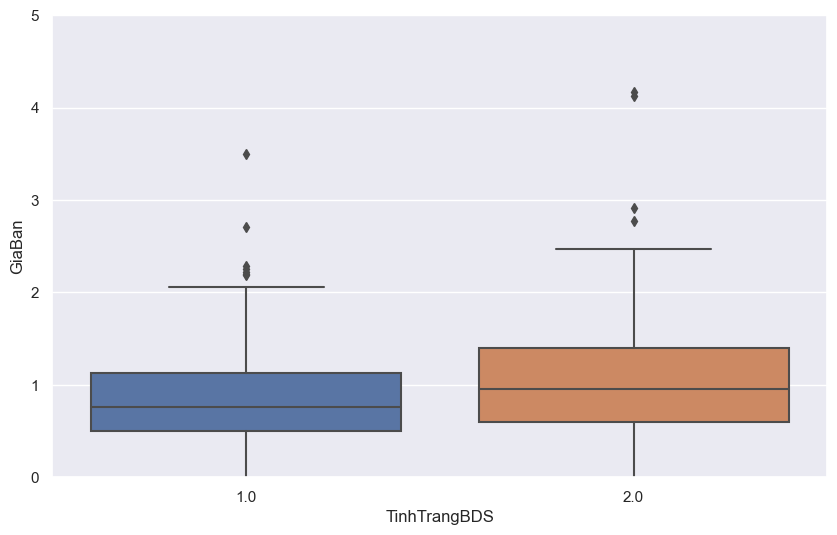

In [318]:
var = 'TinhTrangBDS'
data = pd.concat([y_train_s, X_train_s['TinhTrangBDS']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.ylim(0, 5) 
plt.show()

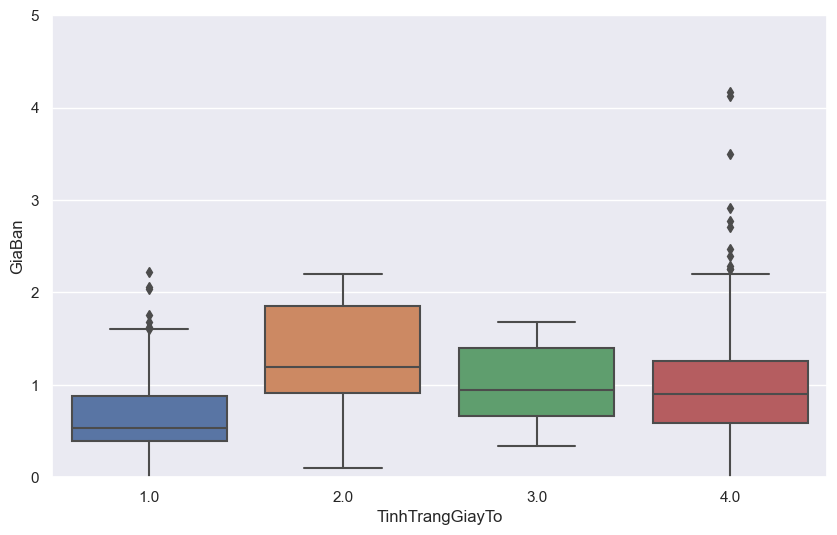

In [319]:
var = 'TinhTrangGiayTo'
data = pd.concat([y_train_s, X_train_s['TinhTrangGiayTo']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.ylim(0, 5) 
plt.show()

* Các thuộc tính này ít ngoại lệ nên chúng ta không cần xử lí ngoại lệ cho các cột này, ta chỉ cần xử lí cột DienTich(m2)

### Xử lý ngoại lệ cột 'DienTich(m2)

In [320]:
norm_upper_limit_train = X_train_s['DienTich(m2)'].mean() + 3 * X_train_s['DienTich(m2)'].std()
norm_lower_limit_train = X_train_s['DienTich(m2)'].mean() - 3 * X_train_s['DienTich(m2)'].std()
norm_upper_limit_test = X_test_s['DienTich(m2)'].mean() + 3 * X_test_s['DienTich(m2)'].std()
norm_lower_limit_test = X_test_s['DienTich(m2)'].mean() - 3 * X_test_s['DienTich(m2)'].std()
norm_upper_limit_val = X_val_s['DienTich(m2)'].mean() + 3 * X_val_s['DienTich(m2)'].std()
norm_lower_limit_val = X_val_s['DienTich(m2)'].mean() - 3 * X_val_s['DienTich(m2)'].std()

In [321]:
df_normal_new_train = X_train_s[(X_train_s['DienTich(m2)'] > norm_lower_limit_train) & ( X_train_s['DienTich(m2)'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['DienTich(m2)'] > norm_lower_limit_test) & ( X_test_s['DienTich(m2)'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['DienTich(m2)'] > norm_lower_limit_val) & ( X_val_s['DienTich(m2)'] < norm_upper_limit_val)]

In [322]:
print("Before Triming Size:", X_train_s.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 559
After Triming Size: 552


<AxesSubplot:>

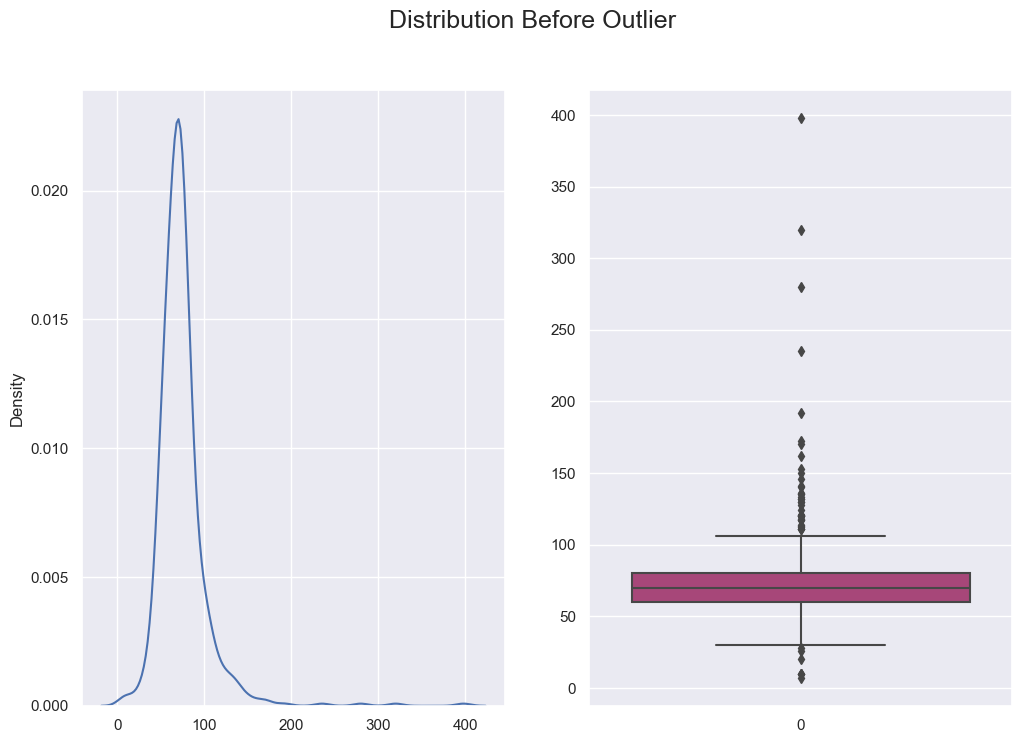

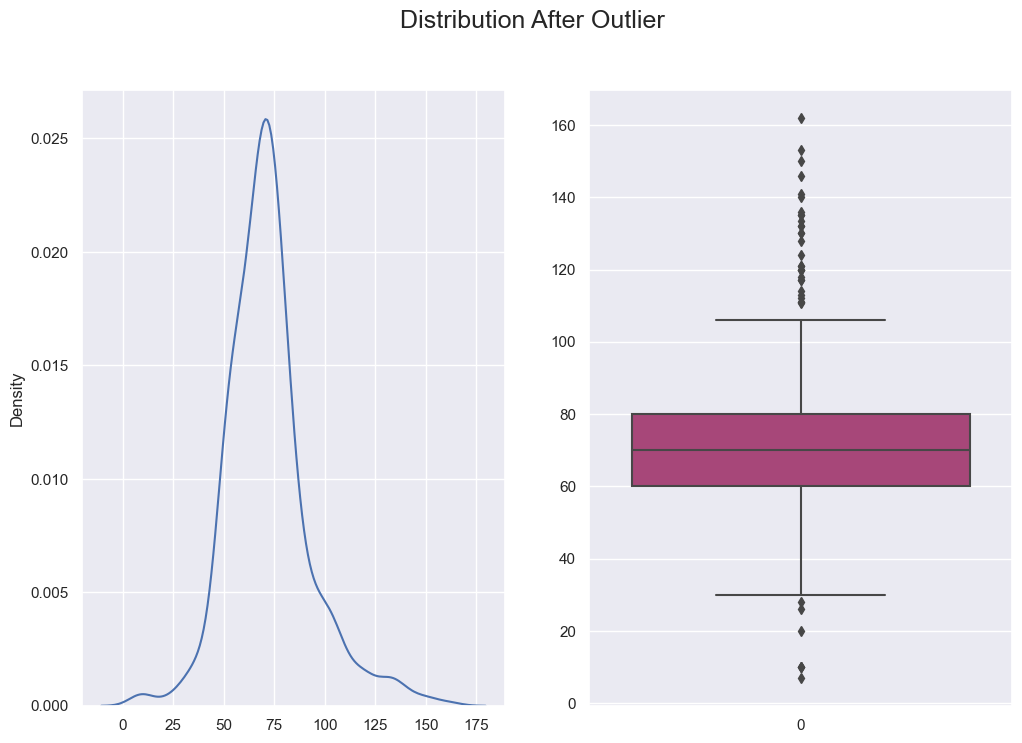

In [323]:
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution Before Outlier", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = X_train_s['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = X_train_s['DienTich(m2)'].values, palette = "magma")
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution After Outlier", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = df_normal_new_train['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = df_normal_new_train['DienTich(m2)'].values, palette = "magma")

In [324]:
def scaler_transform(X_train,X_test,X_val,scaler_type):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'min_max':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'maxabs':
        scaler = MaxAbsScaler()
    elif scaler_type == 'norma':
        scaler = Normalizer()
    elif scaler_type == 'quantil':
        scaler = QuantileTransformer(n_quantiles=620)
    elif scaler_type == 'powert':
        scaler = PowerTransformer()
    else:
        raise ValueError('Scaler not recognized')
    X_train_tranformed =  pd.DataFrame(scaler.fit_transform(X_train))
    X_test_tranformed  =  pd.DataFrame(scaler.transform(X_test))
    X_val_tranformed   =  pd.DataFrame(scaler.transform(X_val))
    return X_train_tranformed,X_test_tranformed,X_val_tranformed

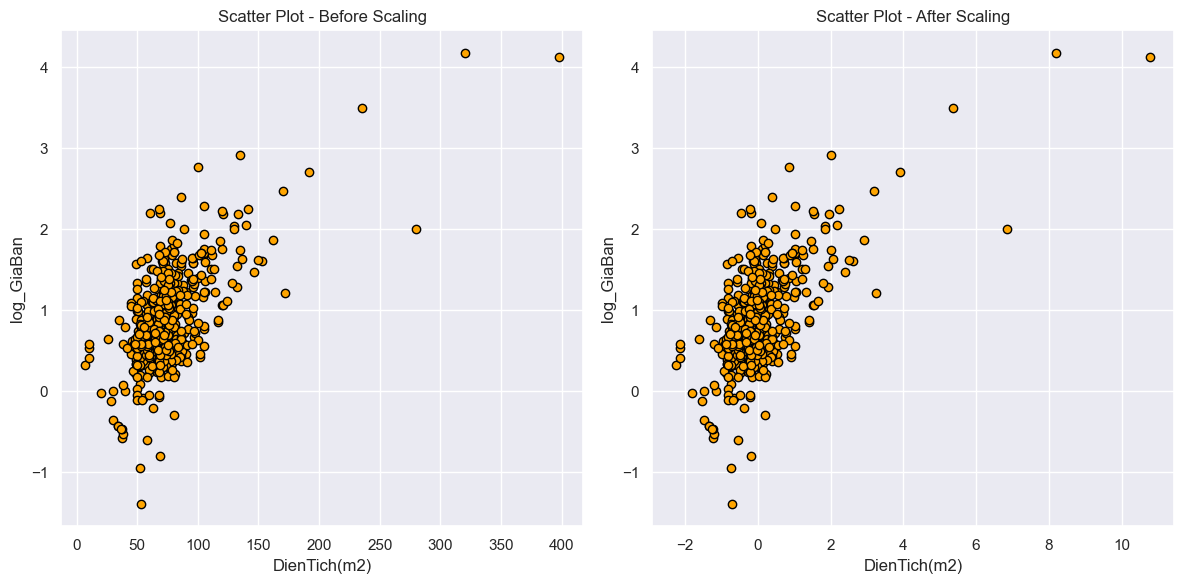

In [325]:
fig, axes = plt.subplots(1,2 ,figsize=(12, 6))
axes[0].scatter(X_train_s['DienTich(m2)'], y_train_s,facecolor='orange', edgecolor='black')
axes[0].set_xlabel('DienTich(m2)')
axes[0].set_ylabel('log_GiaBan')
axes[0].set_title('Scatter Plot - Before Scaling')
X_train_s, X_test_s, X_val_s = scaler_transform(X_train_s, X_test_s, X_val_s,'standard')
axes[1].scatter(X_train_s[0], y_train_s,facecolor='orange', edgecolor='black')
axes[1].set_xlabel('DienTich(m2)')
axes[1].set_ylabel('log_GiaBan')
axes[1].set_title('Scatter Plot - After Scaling')
plt.tight_layout()
plt.show()

MAE và MSE là hai độ đo đánh giá mức độ chính xác của mô hình dự đoán so với giá trị thực tế.

MAE (Mean Absolute Error): là trung bình cộng của giá trị tuyệt đối của sai số giữa giá trị dự đoán và giá trị thực tế. MAE càng thấp thì mô hình dự đoán càng chính xác.

MSE (Mean Squared Error): là trung bình cộng của bình phương sai số giữa giá trị dự đoán và giá trị thực tế. MSE càng thấp thì mô hình dự đoán càng chính xác.

### Sử dụng mô hình LinearRegression

In [326]:
X_train_linear=X_train_s.copy()
X_test_linear=X_test_s.copy()
X_val_linear=X_val_s.copy()
y_train_linear=y_train_s.copy()
y_test_linear=y_test_s.copy()
y_val_linear=y_val_s.copy()

In [327]:
model = LinearRegression()
model.fit(X_train_linear, y_train_linear)
y_val_pred = model.predict(X_val_linear)
r2_val_before = r2_score(y_val_linear, y_val_pred).round(5)
y_test_pred = model.predict(X_test_linear)
r2_test_before = r2_score(y_test_linear, y_test_pred).round(5)
mae_val_before = mean_absolute_error(y_val_linear, y_val_pred).round(5)
mae_test_before = mean_absolute_error(y_test_linear, y_test_pred).round(5)
mse_val_before = mean_squared_error(y_val_linear,y_val_pred).round(5)
mse_test_before = mean_squared_error(y_test_linear,y_test_pred).round(5)
rmse_val_before = mean_squared_error(y_val_linear, y_val_pred, squared=False).round(5)
rmse_test_before = mean_squared_error(y_test_linear, y_test_pred, squared=False).round(5)
print("r2_score in validation:", r2_val_before)
print("r2_score in test:", r2_test_before)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before))
print("Test error (MAE) in test: {}".format(mae_test_before))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before))
print("Test error (MSE) in test: {}".format(mse_test_before))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_before))
print("Test error (RMSE) in test: {}".format(rmse_test_before))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_val_linear, 'Nhãn dự đoán': y_val_pred, 'Chênh lệch': abs(y_val_linear - y_val_pred)})
print(df)

r2_score in validation: 0.5102
r2_score in test: 0.41892

Test error (MAE) in validation: 0.26787
Test error (MAE) in test: 0.3046

Test error (MSE) in validation: 0.12661
Test error (MSE) in test: 0.15447

Test error (RMSE) in validation: 0.35583
Test error (RMSE) in test: 0.39303

     Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
195           0.405465      0.574015    0.168550
366           0.587787      0.889534    0.301747
407           0.693147      0.855089    0.161942
321           0.482426      0.619942    0.137516
504          -0.634878      0.266250    0.901129
..                 ...           ...         ...
56            1.335001      1.284409    0.050592
412           0.438255      0.461424    0.023169
489           1.040277      0.941474    0.098803
446           0.788457      0.723322    0.065135
414           1.348073      1.010364    0.337709

[187 rows x 3 columns]


* Hiệu chỉnh mô hình 

In [328]:
model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_linear, y_train_linear)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))


Best parameters: {'copy_X': True, 'fit_intercept': True}


* Truyền tham số tốt nhất vào để chạy trên tập test

In [329]:
model = LinearRegression(fit_intercept = True, copy_X = True)
model.fit(X_train_linear, y_train_linear)
y_val_pred = model.predict(X_val_linear)
r2_val_after = r2_score(y_val_linear, y_val_pred)
y_test_pred = model.predict(X_test_linear)
r2_test_after = r2_score(y_test_linear, y_test_pred)
mae_test_after = mean_absolute_error(y_test_linear,y_test_pred).round(5)
mae_val_after = mean_absolute_error(y_val_linear,y_val_pred).round(5)
mse_test_after = mean_squared_error(y_test_linear,y_test_pred).round(5)
mse_val_after = mean_squared_error(y_val_linear,y_val_pred).round(5)
rmse_test_after = mean_squared_error(y_test_linear,y_test_pred,squared = False).round(5)
rmse_val_after = mean_squared_error(y_val_linear,y_test_pred,squared = False).round(5)
print("R2-score in  validation:", r2_val_after)
print("R2-score in test:", r2_test_after)
print()
print("Test error (MAE) in test: {}".format(mae_test_after))
print("Test error (MAE) in validation: {}".format(mae_val_after))
print()
print("Test error (MSE) in test: {}".format(mse_test_after))
print("Test error (MSE) in validation: {}".format(mse_val_after))
print()
print("Test error (RMSE) in test: {}".format(rmse_test_after))
print("Test error (RMSE) in validation: {}".format(rmse_val_after))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_test_linear, 'Nhãn dự đoán': y_test_pred,'Chênh lệch': abs(y_test_linear-y_test_pred)})
print(df)


R2-score in  validation: 0.5101975551496158
R2-score in test: 0.41892484250236006

Test error (MAE) in test: 0.3046
Test error (MAE) in validation: 0.26787

Test error (MSE) in test: 0.15447
Test error (MSE) in validation: 0.12661

Test error (RMSE) in test: 0.39303
Test error (RMSE) in validation: 0.62924

     Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
731          -0.597837      0.404061    1.001898
525           0.553885      0.757767    0.203882
409           1.722767      1.331851    0.390915
147           0.357674      0.861102    0.503428
36            1.887070      1.127454    0.759616
..                 ...           ...         ...
845           1.029619      0.834351    0.195269
578           1.163151      1.035600    0.127550
526           0.512824      0.757767    0.244944
91            0.412110      0.872584    0.460474
708           0.916291      0.662081    0.254210

[187 rows x 3 columns]


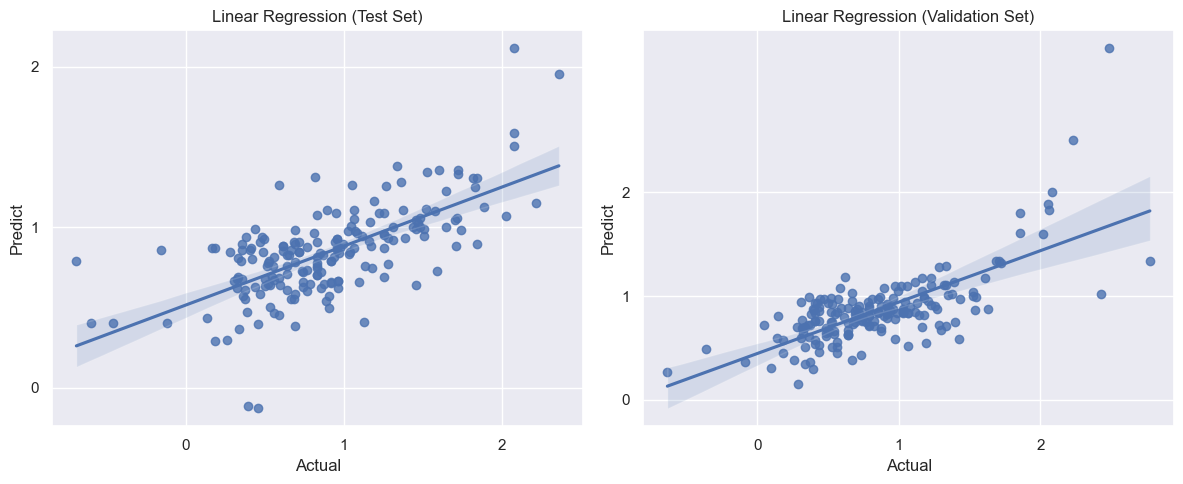

In [330]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_linear, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_linear, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

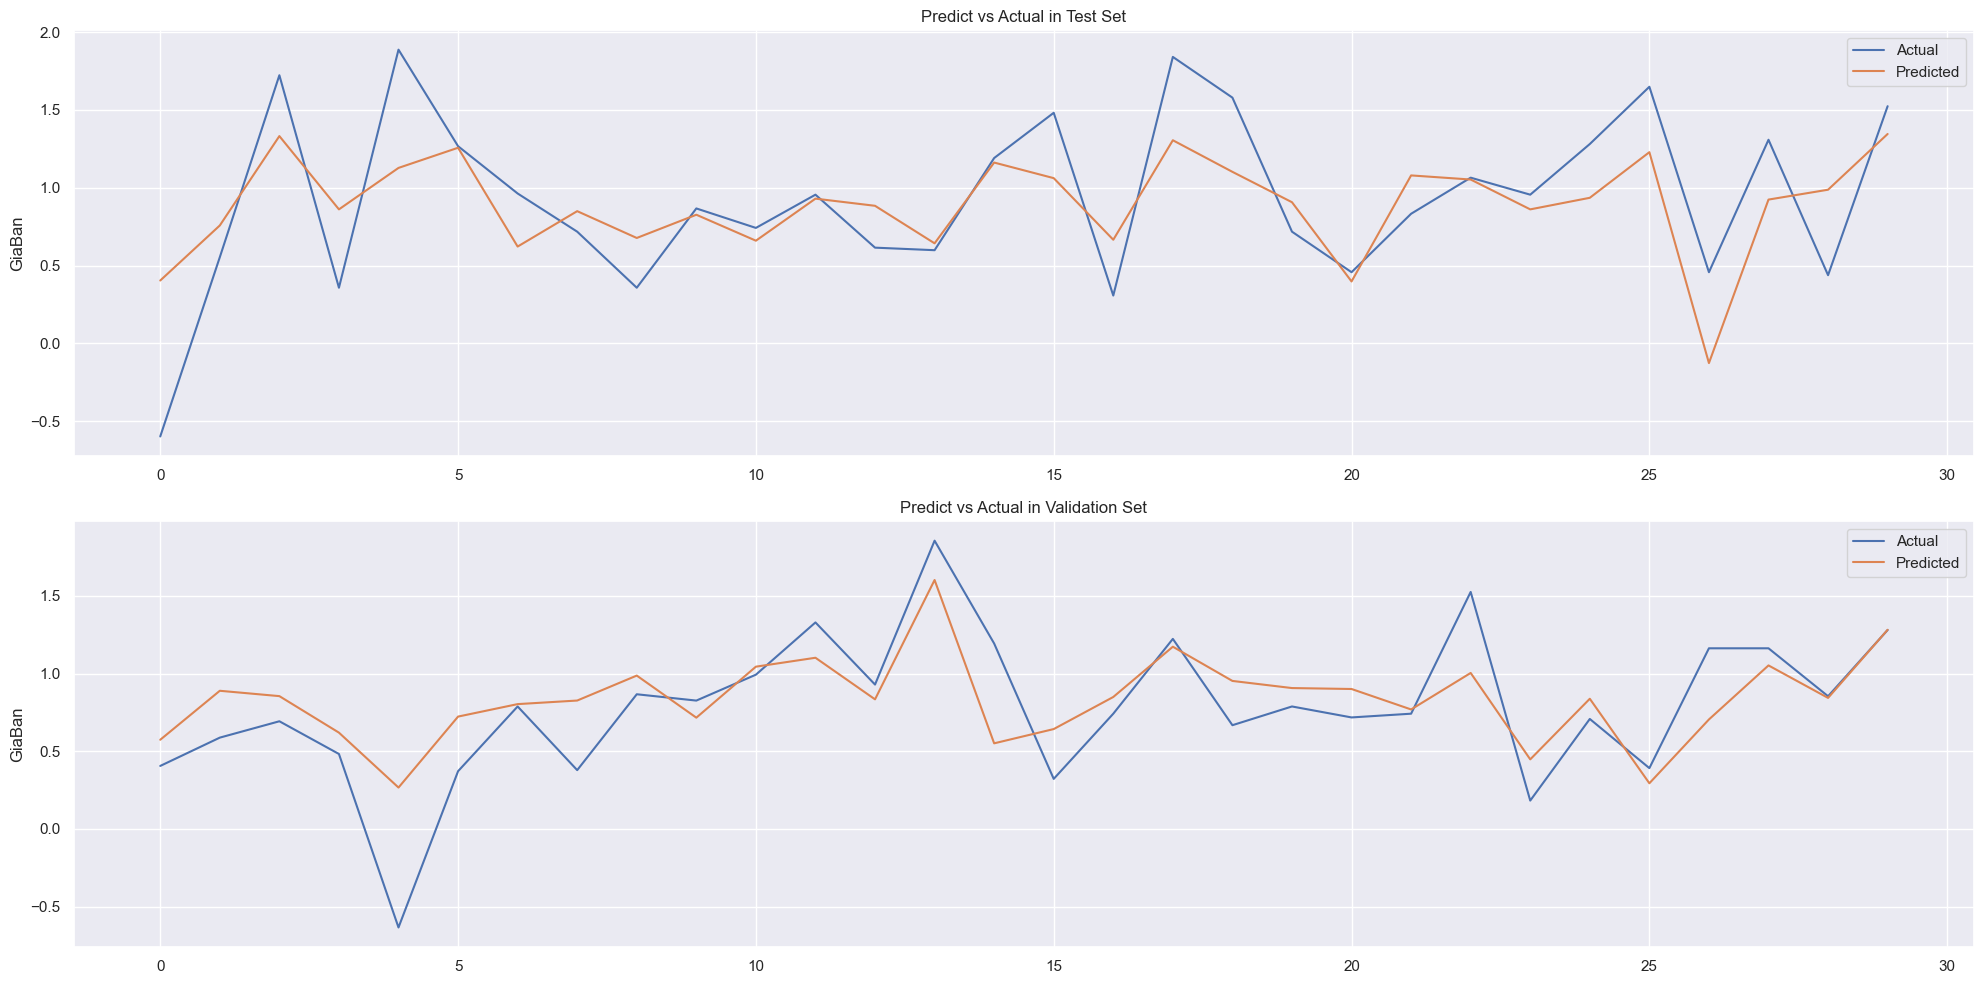

In [331]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_linear[:30]), label='Actual')
axes[0].plot(y_test_pred[:30], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_linear[:30]), label='Actual')
axes[1].plot(y_val_pred[:30], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


In [332]:
data = {'Metric': ['R2-score', 'MAE', 'MSE', 'RMSE'],
        'Before Optimization (Validation)': [r2_val_before, mae_val_before, mse_val_before, rmse_val_before],
        'After Optimization (Validation)': [r2_val_after, mae_val_after, mse_val_after, rmse_val_after],
        'Before Optimization (Test)': [r2_test_before, mae_test_before, mse_test_before, rmse_test_before],
        'After Optimization (Test)': [r2_test_after, mae_test_after, mse_test_after, rmse_test_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   Before Optimization (Test) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.5102  │                          0.510198 │                      0.41892 │                    0.418925 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.26787 │                          0.26787  │                      0.3046  │                    0.3046   │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼──

### Sử dụng mô hình RandomForestRegressor

In [333]:
X_train_randomforest=X_train_s.copy()
X_test_randomforest=X_test_s.copy()
X_val_randomforest=X_val_s.copy()
y_train_randomforest=y_train_s.copy()
y_test_randomforest=y_test_s.copy()
y_val_randomforest=y_val_s.copy()

In [334]:
model = RandomForestRegressor(random_state = 20)
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_before = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_before = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_val_before = mean_absolute_error(y_val_randomforest, y_val_pred).round(5)
mae_test_before = mean_absolute_error(y_test_randomforest, y_test_pred).round(5)
mse_val_before = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
mse_test_before = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
rmse_val_before= mean_squared_error(y_val_randomforest, y_val_pred, squared=False).round(5)
rmse_test_before= mean_squared_error(y_test_randomforest, y_test_pred, squared=False).round(5)
print("R2-score in validation: ", r2_val_before)
print("R2-score in test: ", r2_test_before)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before))
print("Test error (MAE) in  test: {}".format(mae_test_before))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before))
print("Test error (MSE) in test: {}".format(mse_test_before))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_before))
print("Test error (RMSE) in test: {}".format(rmse_test_before))
print
df = pd.DataFrame({'Giá trị nhãn đúng': y_val_randomforest, 'Nhãn dự đoán': y_val_pred, 'Chênh lệch': abs(y_val_randomforest - y_val_pred)})
print(df)

R2-score in validation:  0.27854
R2-score in test:  0.36453

Test error (MAE) in validation: 0.3161
Test error (MAE) in  test: 0.30679

Test error (MSE) in validation: 0.1865
Test error (MSE) in test: 0.16893

Test error (RMSE) in validation: 0.43185
Test error (RMSE) in test: 0.41101
     Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
195           0.405465      0.316455    0.089011
366           0.587787      0.931256    0.343469
407           0.693147      0.661062    0.032085
321           0.482426      0.410473    0.071953
504          -0.634878     -0.005637    0.629241
..                 ...           ...         ...
56            1.335001      1.109309    0.225692
412           0.438255      0.804750    0.366495
489           1.040277      1.013132    0.027145
446           0.788457      0.718133    0.070325
414           1.348073      1.100669    0.247404

[187 rows x 3 columns]


#### Hiệu chỉnh mô hình

In [335]:
model = RandomForestRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5, 10]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_randomforest, y_train_randomforest)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


#### Truyền tham số tốt nhất để chạy trên tập test

In [336]:
model = RandomForestRegressor(max_depth=5, min_samples_split = 2, n_estimators=200, random_state=20) 
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_after = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_after = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_test_after = mean_absolute_error(y_test_randomforest,y_test_pred).round(5)
mae_val_after = mean_absolute_error(y_val_randomforest,y_val_pred).round(5)
mse_test_after = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
mse_val_after = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
rmse_test_after = mean_squared_error(y_test_randomforest,y_test_pred,squared = False).round(5)
rmse_val_after = mean_squared_error(y_val_randomforest,y_val_pred,squared = False).round(5)
print("R2-score trên tập validation:", r2_val_after)
print("R2-score trên tập test:", r2_test_after)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after))
print("Test error (MAE) in test: {}".format(mae_test_after))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after))
print("Test error (MSE) in test: {}".format(mse_test_after))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_after))
print("Test error (RMSE) in test: {}".format(rmse_test_after))
print()
# Tạo DataFrame chứa nhãn đúng và nhãn dự đoán
df = pd.DataFrame({'Giá trị nhãn đúng': y_test_randomforest, 'Nhãn dự đoán': y_test_pred,'Chênh lệch': abs(y_test_randomforest-y_test_pred)})
print(df)


R2-score trên tập validation: 0.5101
R2-score trên tập test: 0.41943

Test error (MAE) in validation: 0.26703
Test error (MAE) in test: 0.30267

Test error (MSE) in validation: 0.12664
Test error (MSE) in test: 0.15434

Test error (RMSE) in validation: 0.35586
Test error (RMSE) in test: 0.39286

     Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
731          -0.597837     -0.026136    0.571701
525           0.553885      0.724835    0.170950
409           1.722767      1.389665    0.333101
147           0.357674      0.875302    0.517628
36            1.887070      1.015563    0.871507
..                 ...           ...         ...
845           1.029619      0.887702    0.141918
578           1.163151      0.980840    0.182311
526           0.512824      0.724835    0.212011
91            0.412110      0.955244    0.543134
708           0.916291      0.584404    0.331887

[187 rows x 3 columns]


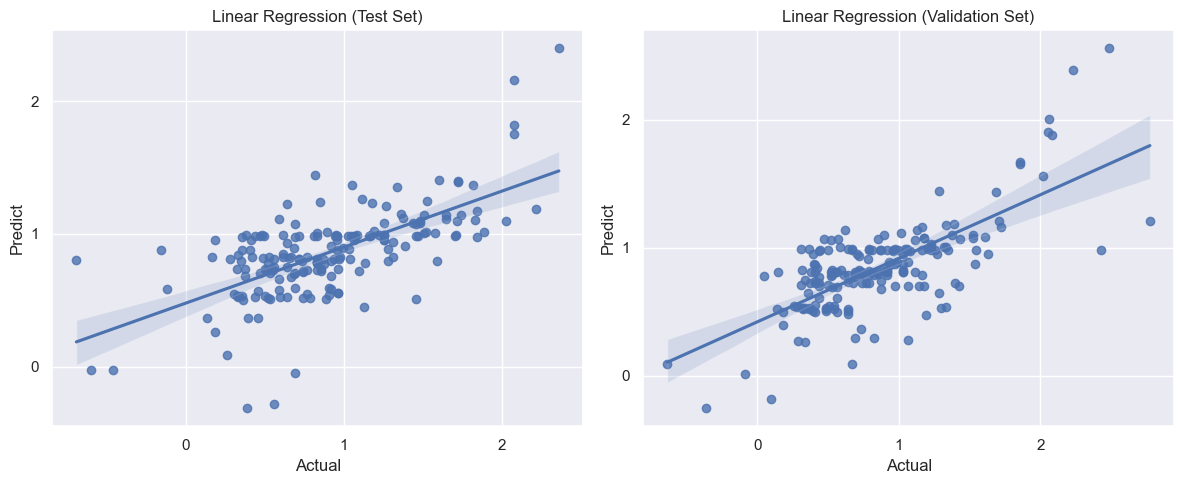

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_randomforest, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_randomforest, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()


=>nhìn vào đồ thị t thấy có sự tuyến tính giữa 2 biến,
tuy nhiên cái khoảng (2,.. trở lên) có cái chi đó .......  
=> khoảng le còn nhỏ còn được
=> thể hiện sự tương quan giữa 2 biến
=> trong cùng 1 khoảng giá trị, cái actual cho thấy sự đa dạng 
=> độ phân bố đều và tập trung tại 1 chõ có độ chính xác tốt

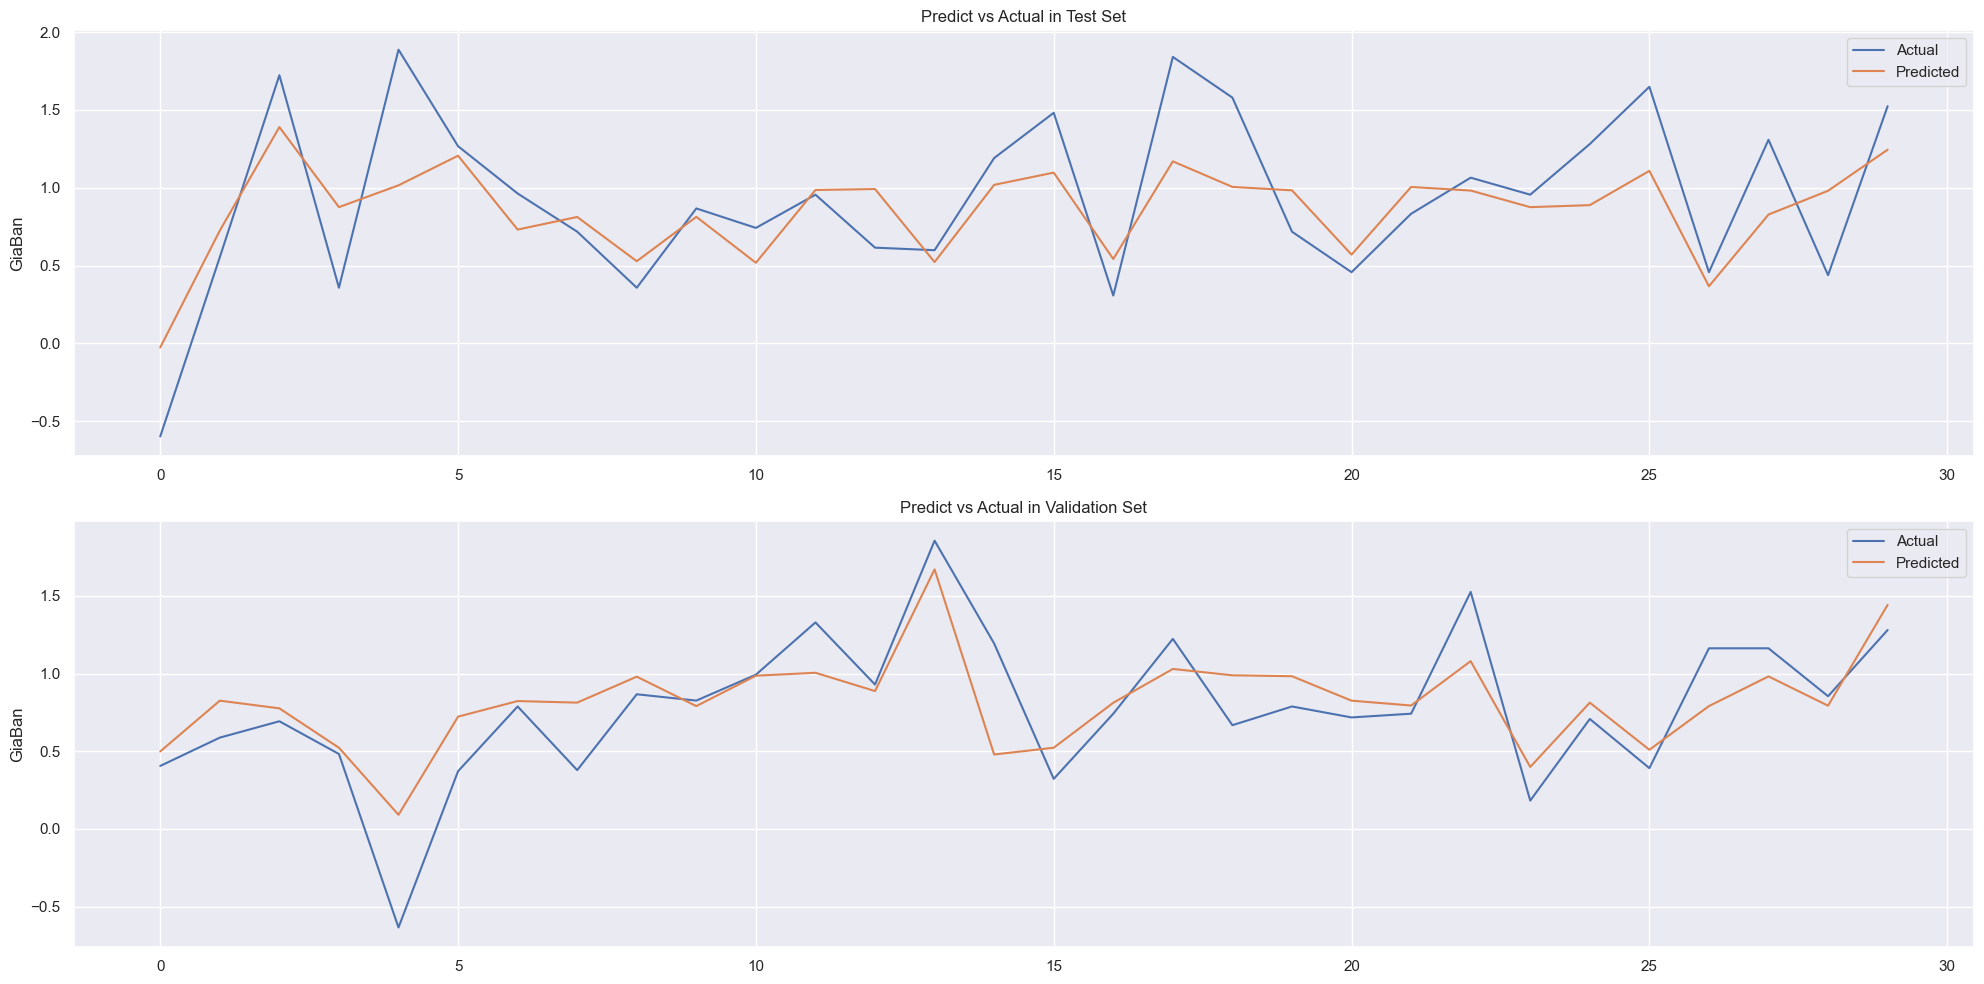

In [338]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_randomforest[:30]), label='Actual')
axes[0].plot(y_test_pred[:30], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_randomforest[:30]), label='Actual')
axes[1].plot(y_val_pred[:30], label='Predicted')
axes[1].legend()

plt.tight_layout()
plt.show()


In [339]:
data = {'Metric': ['R2-score', 'MAE', 'MSE', 'RMSE'],
        'Before Optimization (Validation)': [r2_val_before, mae_val_before, mse_val_before, rmse_val_before],
        'After Optimization (Validation)': [r2_val_after, mae_val_after, mse_val_after, rmse_val_after],
        'Before Optimization (Test)': [r2_test_before, mae_test_before, mse_test_before, rmse_test_before],
        'After Optimization (Test)': [r2_test_after, mae_test_after, mse_test_after, rmse_test_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   Before Optimization (Test) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.27854 │                           0.5101  │                      0.36453 │                     0.41943 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.3161  │                           0.26703 │                      0.30679 │                     0.30267 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼──

### Sử dụng mô hình GradientBoostingRegressor

In [340]:
X_train_boot = X_train_s.copy()
X_test_boot = X_test_s.copy()
X_val_boot = X_val_s.copy()
y_train_boot = y_train_s.copy()
y_test_boot = y_test_s.copy()
y_val_boot = y_val_s.copy()

In [341]:
model = GradientBoostingRegressor(random_state = 20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_before = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_before = r2_score(y_test_boot, y_test_pred).round(5)
mae_val_before = mean_absolute_error(y_val_boot, y_val_pred).round(5)
mae_test_before = mean_absolute_error(y_test_boot, y_test_pred).round(5)
mse_val_before = mean_squared_error(y_val_boot,y_val_pred).round(5)
mse_test_before = mean_squared_error(y_test_boot,y_test_pred).round(5)
rmse_val_before= mean_squared_error(y_val_boot, y_val_pred, squared=False).round(5)
rmse_test_before= mean_squared_error(y_test_boot, y_test_pred, squared=False).round(5)
print("R2-score in validation: ", r2_val_before)
print("R2-score in test: ", r2_test_before)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before))
print("Test error (MAE) in  test: {}".format(mae_test_before))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before))
print("Test error (MSE) in test: {}".format(mse_test_before))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_before))
print("Test error (RMSE) in test: {}".format(rmse_test_before))
print
df = pd.DataFrame({'Giá trị nhãn đúng': y_val_boot, 'Nhãn dự đoán': y_val_pred, 'Chênh lệch': abs(y_val_boot - y_val_pred)})
print(df)


R2-score in validation:  0.48381
R2-score in test:  0.42869

Test error (MAE) in validation: 0.27943
Test error (MAE) in  test: 0.30091

Test error (MSE) in validation: 0.13343
Test error (MSE) in test: 0.15188

Test error (RMSE) in validation: 0.36529
Test error (RMSE) in test: 0.38971
     Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
195           0.405465      0.463216    0.057750
366           0.587787      0.857955    0.270168
407           0.693147      0.735970    0.042823
321           0.482426      0.556672    0.074246
504          -0.634878     -0.250498    0.384381
..                 ...           ...         ...
56            1.335001      0.930280    0.404721
412           0.438255      0.674734    0.236479
489           1.040277      0.996828    0.043449
446           0.788457      0.662037    0.126420
414           1.348073      0.979198    0.368875

[187 rows x 3 columns]


## Hiệu Chỉnh mô hình

In [342]:
model = GradientBoostingRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_boot, y_train_boot)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [343]:
model = GradientBoostingRegressor(n_estimators = 50, max_depth = 3, learning_rate= 0.1,random_state=20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_after = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_after= r2_score(y_test_boot, y_test_pred).round(5)
mae_test_after = mean_absolute_error(y_test_boot,y_test_pred).round(5)
mae_val_after = mean_absolute_error(y_val_boot,y_val_pred).round(5)
mse_test_after = mean_squared_error(y_test_boot,y_test_pred).round(5)
mse_val_after = mean_squared_error(y_val_boot,y_val_pred).round(5)
rmse_test_after = mean_squared_error(y_test_boot,y_test_pred,squared = False).round(5)
rmse_val_after = mean_squared_error(y_val_boot,y_val_pred,squared = False).round(5)
print("R2-score trên tập validation:", r2_val_after)
print("R2-score trên tập test:", r2_test_after)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after))
print("Test error (MAE) in test: {}".format(mae_test_after))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after))
print("Test error (MSE) in test: {}".format(mse_test_after))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_after))
print("Test error (RMSE) in test: {}".format(rmse_test_after))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_test_boot, 'Nhãn dự đoán': y_test_pred,'Chênh lệch': abs(y_test_boot-y_test_pred)})
print(df)

R2-score trên tập validation: 0.5166
R2-score trên tập test: 0.44244

Test error (MAE) in validation: 0.27275
Test error (MAE) in test: 0.29982

Test error (MSE) in validation: 0.12496
Test error (MSE) in test: 0.14822

Test error (RMSE) in validation: 0.3535
Test error (RMSE) in test: 0.385

     Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
731          -0.597837     -0.085295    0.512542
525           0.553885      0.670654    0.116769
409           1.722767      1.319701    0.403065
147           0.357674      0.851471    0.493797
36            1.887070      1.049031    0.838038
..                 ...           ...         ...
845           1.029619      0.906118    0.123501
578           1.163151      1.008009    0.155142
526           0.512824      0.670654    0.157830
91            0.412110      0.960948    0.548838
708           0.916291      0.552248    0.364043

[187 rows x 3 columns]


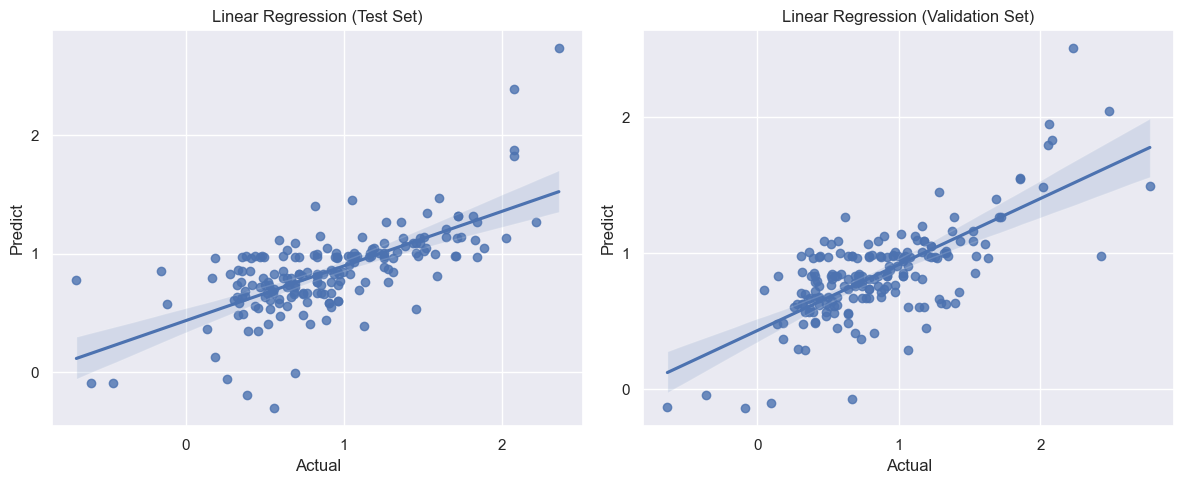

In [344]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_boot, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_boot, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()


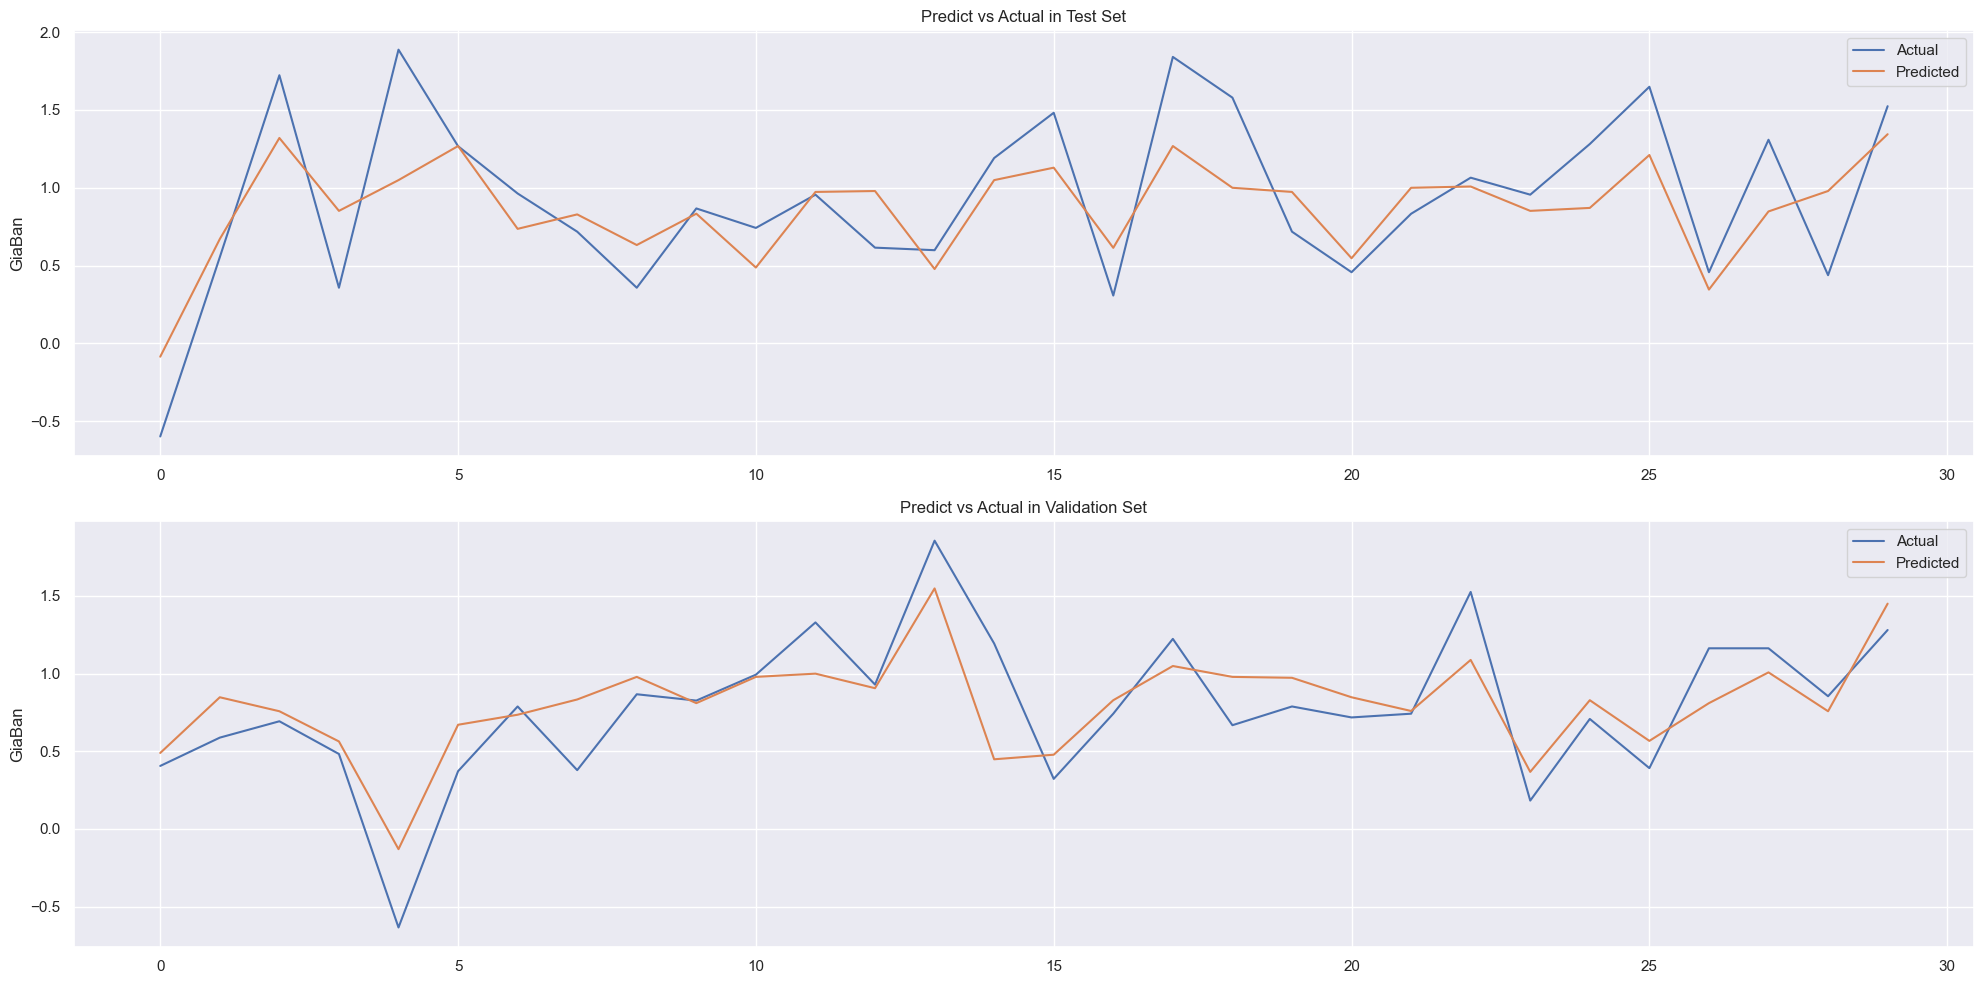

In [345]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_boot[:30]), label='Actual')
axes[0].plot(y_test_pred[:30], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_boot[:30]), label='Actual')
axes[1].plot(y_val_pred[:30], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


In [346]:
data = {'Metric': ['R2-score', 'MAE', 'MSE', 'RMSE'],
        'Before Optimization (Validation)': [r2_val_before, mae_val_before, mse_val_before, rmse_val_before],
        'After Optimization (Validation)': [r2_val_after, mae_val_after, mse_val_after, rmse_val_after],
        'Before Optimization (Test)': [r2_test_before, mae_test_before, mse_test_before, rmse_test_before],
        'After Optimization (Test)': [r2_test_after, mae_test_after, mse_test_after, rmse_test_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   Before Optimization (Test) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.48381 │                           0.5166  │                      0.42869 │                     0.44244 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.27943 │                           0.27275 │                      0.30091 │                     0.29982 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼──

In [347]:
linear_pipeline = Pipeline([
    ('linear', LinearRegression())  
])
randomforest_pipeline = Pipeline([ 
    ('randomforest', RandomForestRegressor(max_depth = 5, min_samples_split = 2, n_estimators = 200,random_state=20))  # Mô hình Random Forest Regression
])
gradientboost_pipeline = Pipeline([ 
    ('gradientboost', GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=20))  # Mô hình Gradient Boosting Regression
])
stacked_model = StackingRegressor(
    estimators=[('linear', linear_pipeline), ('randomforest', randomforest_pipeline), ('gradientboost', gradientboost_pipeline)]
)
stacked_model.fit(X_train_s, y_train_s)
y_val_pred_stacked = stacked_model.predict(X_val_s)
r2_val_stacked = r2_score(y_val_s, y_val_pred_stacked)
mse_val_stacked = mean_squared_error(y_val_s, y_val_pred_stacked)
mae_val_stacked = mean_absolute_error(y_val_s, y_val_pred_stacked)
y_test_pred_stacked = stacked_model.predict(X_test_s)
r2_test_stacked = r2_score(y_test_s, y_test_pred_stacked)
mse_test_stacked = mean_squared_error(y_test_s, y_test_pred_stacked)
mae_test_stacked = mean_absolute_error(y_test_s, y_test_pred_stacked)
print("R2-score on validation set (Stacked Model):", r2_val_stacked)
print("MSE on validation set (Stacked Model):", mse_val_stacked)
print("MAE on validation set (Stacked Model):", mae_val_stacked)
print()
print("R2-score on test set (Stacked Model):", r2_test_stacked)
print("MSE on test set (Stacked Model):", mse_test_stacked)
print("MAE on test set (Stacked Model):", mae_test_stacked)

R2-score on validation set (Stacked Model): 0.5312777460931092
MSE on validation set (Stacked Model): 0.1211653618878567
MAE on validation set (Stacked Model): 0.26508311221530173

R2-score on test set (Stacked Model): 0.4482409702878789
MSE on test set (Stacked Model): 0.14667894282590394
MAE on test set (Stacked Model): 0.29749857488101866
